# 0 Configuration

In [1]:
config = {
    "overview": {

    },
    "fe": {

    },
    "model": {
        "kmeans": True
    },
    "explain": {

    }
}

***
# 1 Dependencies import

## 1.0 Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer

from math import ceil

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

np.random.seed(0)

***
## 1.1 Features selection

In [3]:
def get_categorical_features_name(dataset, split_by_unique_count=True, split_count=10):
    features_name = dataset.select_dtypes(["object", "bool"]).columns
    if split_by_unique_count:
        less_uniques = [feature_name for feature_name in features_name if dataset[feature_name].nunique() <= split_count]
        lot_uniques = features_name.difference(less_uniques).tolist()
        return (less_uniques, lot_uniques)
    else:
        return features_name.values.tolist()

In [4]:
def get_numerical_features_name(dataset):
    features_name = dataset.select_dtypes(["int64", "float64"]).columns.values.tolist()
    return features_name

In [5]:
def progressiveFeatureSelection(df, n_clusters=3, max_features=4,):
    feature_list = list(df.columns)
    selected_features = list()
    # select starting feature
    initial_feature = ""
    high_score = 0
    for feature in feature_list:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        data_ = df[feature]
        labels = kmeans.fit_predict(data_.to_frame())
        score_ = silhouette_score(data_.to_frame(), labels)
        print("Proposed new feature {} with score {}". format(feature, score_))
        if score_ >= high_score:
            initial_feature = feature
            high_score = score_
    print("The initial feature is {} with a silhouette score of {}.".format(initial_feature, high_score))
    feature_list.remove(initial_feature)
    selected_features.append(initial_feature)
    for _ in range(max_features-1):
        high_score = 0
        selected_feature = ""
        print("Starting selection {}...".format(_))
        for feature in feature_list:
            selection_ = selected_features.copy()
            selection_.append(feature)
            kmeans = KMeans(n_clusters=n_clusters, random_state=42)
            data_ = df[selection_]
            labels = kmeans.fit_predict(data_)
            score_ = silhouette_score(data_, labels)
            print("Proposed new feature {} with score {}". format(feature, score_))
            if score_ > high_score:
                selected_feature = feature
                high_score = score_
        selected_features.append(selected_feature)
        feature_list.remove(selected_feature)
        print("Selected new feature {} with score {}". format(selected_feature, high_score))
    return selected_features

***
## 1.2 Pipeline construction

In [6]:
def evaluate(dataset, model, scoring="neg_root_mean_squared_error"):

    ### DATASET PREPARATION ###

    # categorical_cols = get_categorical_features_name(dataset, split_by_unique_count=False)
    numerical_cols = get_numerical_features_name(dataset)

    # X = dataset[numerical_cols + categorical_cols]
    X = dataset[numerical_cols]

    ### PIPELINE CONSTRUCTION ###

    num_pipe = Pipeline(steps=[
        ("simple_imputer", SimpleImputer(strategy="mean")),
        # ("std_scaler", StandardScaler())
        ("minmax_scaler", MinMaxScaler())
    ])

    # cat_pipe = Pipeline(steps=[
    #     ("simple_imputer", SimpleImputer(strategy="most_frequent")),
    #     ("ordinal_encoder", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
    #     ("simple_imputer_bis", SimpleImputer(strategy="mean")),
    #     ("std_scaler", StandardScaler())
    # ])

    preprocessor = ColumnTransformer([
        ("num_pipe", num_pipe, numerical_cols),
        # ("cat_pipe", cat_pipe, categorical_cols)
    ])

    pipeline = Pipeline([
        ("transforms", preprocessor),
        ("model", model)
    ])

    preprocessor.fit(X)
    array_preproc = preprocessor.transform(X)
    data_preproc = pd.DataFrame(data=array_preproc, columns=X.columns)

    return pipeline, preprocessor, data_preproc

***
## 1.3 Cluster evaluation

In [7]:
def elbow_plot(range, data, figsize=(10,10)):
    intertia_list = []
    for n in range:
        kmeans = KMeans(n_clusters=n, random_state=1)
        kmeans.fit(data)
        intertia_list.append(kmeans.inertia_)
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111)
    sns.lineplot(y=intertia_list, x=range, ax=ax)
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Inertia")
    ax.set_xticks(list(range))
    fig.show()

In [8]:
def silhouette_plot(range, data, n_cols=2, figsize=(20, 10), wspace=0.35, hspace=0.35):
    if range[0] == 0:
        raise Exception("Range must not include 0")

    n_rows = ceil(len(range)/n_cols)
    index = 0

    plt.subplots(n_rows, n_cols, figsize=figsize)
    plt.subplots_adjust(wspace=wspace, hspace=hspace)

    for n in range:
        kmeans = KMeans(n, random_state=1)

        plt.subplot(n_rows, n_cols, index+1)
        sv = SilhouetteVisualizer(kmeans, colors="yellowbrick")
        sv.fit(data)

        index += 1
    
    plt.show()

In [9]:
def find_optimal_epsilon(n_neighbors, data):
    neigh = NearestNeighbors(n_neighbors=n_neighbors)
    nbrs = neigh.fit(data)
    distances, indices = nbrs.kneighbors(data)
    distances = np.sort(distances, axis=0)
    distances = distances[:,1]
    plt.plot(distances)

***
## 1.4 Dimensionality reduction

In [10]:
def apply_pca(dataset, columns):
    pca = PCA()
    pca_data = pca.fit_transform(dataset[columns])
    components_name = [f"PC{i+1}" for i in range(pca_data.shape[1])]
    pca_data = pd.DataFrame(data=pca_data, columns=components_name)
    loadings = pd.DataFrame(data=pca.components_.T, columns=components_name, index=columns)
    return pca, pca_data, loadings

In [11]:
def plot_variance(pca, width=8, dpi=100):
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    evr = pca.explained_variance_ratio_

    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )

    cumulative_variance = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cumulative_variance], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )

    fig.set(figwidth=8, dpi=100)
    return axs

***
# 2 Data loading

In [12]:
data = pd.read_csv("data/data_cleaned.csv", delimiter=",")

In [13]:
# data = pd.read_csv("data/data_cleaned.csv", delimiter=",", parse_dates=["order_purchase_timestamp", "order_approved_at", "order_delivered_carrier_date", "order_delivered_customer_date", "order_estimated_delivery_date", "review_creation_date", "review_answer_timestamp", "shipping_limit_date"], infer_datetime_format=True)

***
# 3 Overview

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 18 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       112650 non-null  object 
 1   customer_id                    112650 non-null  object 
 2   order_status                   112650 non-null  object 
 3   order_purchase_timestamp       112650 non-null  object 
 4   order_approved_at              112635 non-null  object 
 5   order_delivered_carrier_date   111456 non-null  object 
 6   order_delivered_customer_date  110196 non-null  object 
 7   order_estimated_delivery_date  112650 non-null  object 
 8   customer_unique_id             108601 non-null  object 
 9   customer_zip_code_prefix       108601 non-null  float64
 10  customer_city                  108601 non-null  object 
 11  customer_state                 108601 non-null  object 
 12  order_item_id                 

In [15]:
data.describe()

,customer_zip_code_prefix,order_item_id,price,freight_value
count,108601.000000,112650.000000,112650.000000,112650.000000
mean,35160.952174,1.197834,120.653739,19.990320
std,29859.695052,0.705124,183.633928,15.806405
min,1003.000000,1.000000,0.850000,0.000000
25%,11347.000000,1.000000,39.900000,13.080000
50%,24355.000000,1.000000,74.990000,16.260000
75%,59065.000000,1.000000,134.900000,21.150000
max,99990.000000,21.000000,6735.000000,409.680000


In [16]:
data.describe(include="object")

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_city,customer_state,product_id,seller_id,shipping_limit_date
count,112650,112650,112650,112650,112635,111456,110196,112650,108601,108601,108601,112650,112650,112650
unique,98666,98666,7,98112,90174,81017,95664,450,95378,4109,27,32951,3095,93318
top,8272b63d03f5f79c56e9e4120aec44ef,fc3d1daec319d62d49bfb5e1f83123e9,delivered,2017-07-16 18:19:25,2018-02-24 03:20:27,2018-05-09 15:48:00,2017-07-31 18:03:02,2017-12-20 00:00:00,4546caea018ad8c692964e3382debd19,sao paulo,SP,aca2eb7d00ea1a7b8ebd4e68314663af,6560211a19b47992c3666cc44a7e94c0,2017-07-21 18:25:23
freq,21,21,110197,21,23,48,21,604,21,17104,45685,527,2033,21


***
# 4 Feeture engineering

## 4.1 Volume

In [17]:
# data["product_volume_cm3"] = data["product_length_cm"] * data["product_height_cm"] * data["product_width_cm"]

***
# 5 Modelisation

## 5.1 RFM

RFM: Récence (dat de la dernière commande), Fréquence (des commandes), Montant (de la dernière commande ou sur une période donnée)

In [18]:
cols_rfm = ["customer_unique_id","order_purchase_timestamp", "order_id", "price"]
data_rfm = data[cols_rfm]
data_rfm.shape

(112650, 4)

In [19]:
data_rfm["order_purchase_timestamp"] = data_rfm["order_purchase_timestamp"].apply(pd.to_datetime)

/tmp/ipykernel_543994/2410668415.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_rfm["order_purchase_timestamp"] = data_rfm["order_purchase_timestamp"].apply(pd.to_datetime)


In [20]:
data_rfm["order_purchase_timestamp"] = data_rfm["order_purchase_timestamp"].dt.date

/tmp/ipykernel_543994/617560309.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_rfm["order_purchase_timestamp"] = data_rfm["order_purchase_timestamp"].dt.date


In [21]:
data_rfm_end = max(data_rfm["order_purchase_timestamp"] + pd.Timedelta(days=1))

data_rfm = data_rfm.groupby("customer_unique_id").agg({
    "order_purchase_timestamp": lambda x: (data_rfm_end - max(x)).days,
    "order_id": "count",
    "price": "sum"
})
data_rfm.columns = ["Récence", "Fréquence", "Montant"]
data_rfm.shape

(95378, 3)

In [22]:
data_rfm.describe()

,Récence,Fréquence,Montant
count,95378.000000,95378.000000,95378.000000
mean,245.858290,1.138638,138.130739
std,153.357996,0.530795,212.011347
min,6.000000,1.000000,0.850000
25%,122.000000,1.000000,45.900000
50%,227.000000,1.000000,86.900000
75%,356.000000,1.000000,149.900000
max,730.000000,21.000000,13440.000000


/opt/anaconda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level 

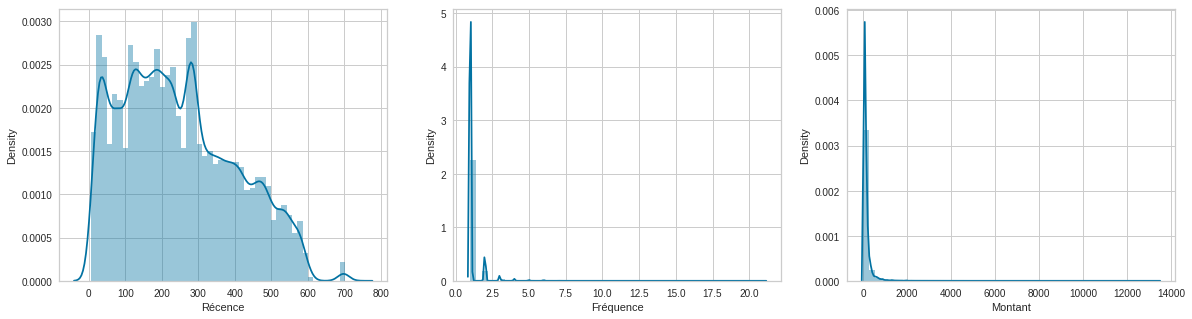

In [23]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
for i, feature in enumerate(data_rfm.columns):
    sns.distplot(data_rfm[feature], ax=axes[i])

<AxesSubplot:>

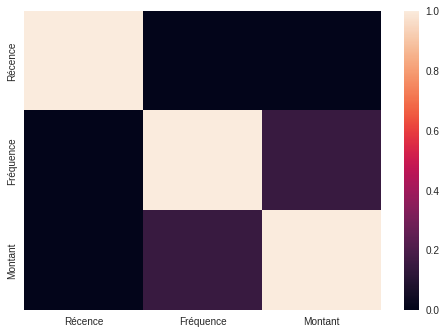

In [24]:
sns.heatmap(data_rfm.corr())

In [25]:
if config["model"]["kmeans"]:

    model = KMeans(n_clusters=6)

    pipeline, preproc, data_preproc = evaluate(data_rfm, model)

In [26]:
data_preproc.head()

,Récence,Fréquence,Montant
0,0.153315,0.0,0.009603
1,0.157459,0.0,0.001343
2,0.741713,0.0,0.005071
3,0.443370,0.0,0.001871
4,0.397790,0.0,0.013330


/opt/anaconda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level 

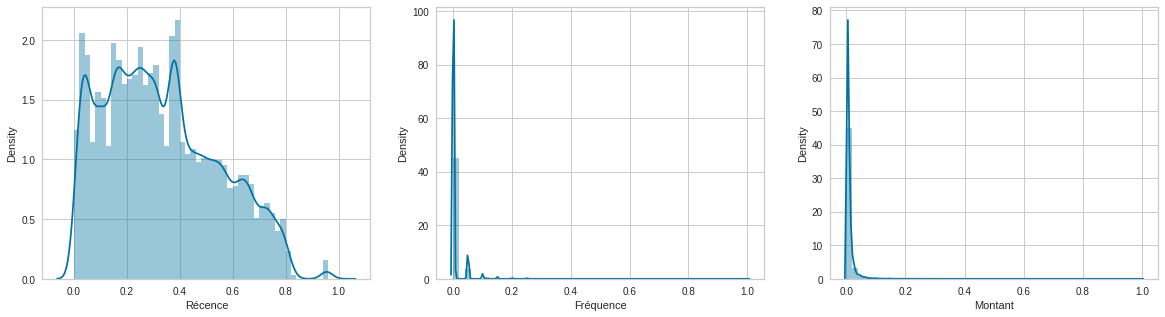

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
for i, feature in enumerate(data_preproc.columns):
    sns.distplot(data_preproc[feature], ax=axes[i])

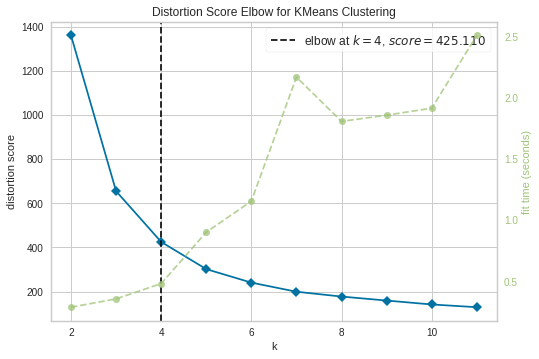

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [28]:
model = KMeans()
elbow_visualizer = KElbowVisualizer(model, k=(2, 12))

elbow_visualizer.fit(data_preproc)
elbow_visualizer.poof()

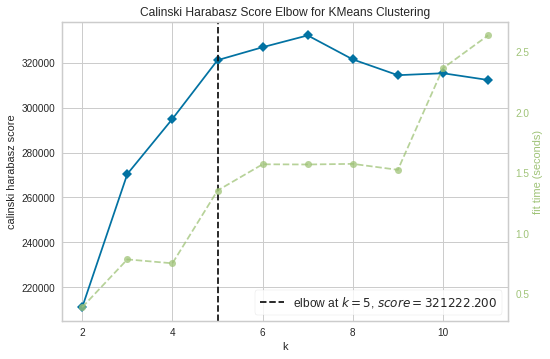

<AxesSubplot:title={'center':'Calinski Harabasz Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='calinski harabasz score'>

In [29]:
model = KMeans()
elbow_visualizer = KElbowVisualizer(model, k=(2, 12), metric="calinski_harabasz")

elbow_visualizer.fit(data_preproc)
elbow_visualizer.poof()

In [ ]:
if False:
    model = KMeans(5)
    silhouette_visualizer = SilhouetteVisualizer(model)

    silhouette_visualizer.fit(data_preproc)
    silhouette_visualizer.poof()

Text(0.5, 0, 'Montant')

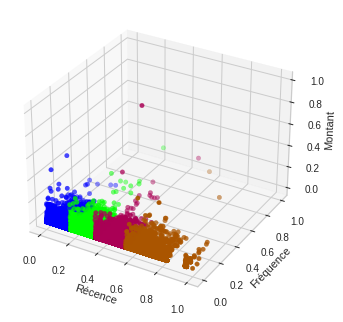

In [31]:
model = KMeans(n_clusters=4).fit(data_preproc)
centers = model.cluster_centers_
fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.scatter3D(data_preproc["Récence"], data_preproc["Fréquence"], data_preproc["Montant"], cmap="brg", c=model.predict(data_preproc))
ax.scatter(centers[:, 0], centers[:, 1], c="black")
ax.set_xlabel("Récence")
ax.set_ylabel("Fréquence")
ax.set_zlabel("Montant")

/opt/anaconda/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


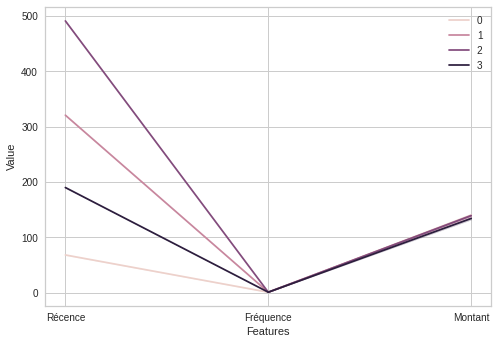

In [32]:
data_rfm_reversed = pd.DataFrame(data_rfm)
data_rfm_reversed.columns = data_preproc.columns

data_rfm_reversed["Customer_id"] = data_preproc.index
data_rfm_reversed["Cluster"] = model.labels_

data_rfm_reversed_melted = pd.melt(data_rfm_reversed.reset_index(), id_vars=["Customer_id", "Cluster"], value_vars=["Récence", "Fréquence", "Montant"], var_name="Features", value_name="Value")

sns.lineplot("Features", "Value", hue="Cluster", data=data_rfm_reversed_melted)
plt.legend()

In [33]:
data_rfm_reversed.groupby("Cluster").agg({
    "Récence": ["mean", "min", "max"],
    "Fréquence": ["mean", "min", "max"],
    "Montant": ["mean", "min", "max", "count"]
})

Récence           Fréquence             Montant                  \
               mean  min  max      mean min max        mean   min       max   
Cluster                                                                       
0         68.364296    6  129  1.136699   1  12  140.420596  2.20   7160.00   
1        320.689173  255  405  1.145879   1  20  139.185905  2.29  13440.00   
2        490.873971  406  730  1.130379   1  21  139.422196  3.50   6735.00   
3        190.082379  130  255  1.139062   1  20  134.243797  0.85   4099.99   

                
         count  
Cluster         
0        25633  
1        24911  
2        17242  
3        27592

***
### 5.1.X PCA

In [ ]:
# pca, pca_data, loadings = apply_pca(dataset=data_preproc, columns=["product_weight_g", "product_volume_cm3"])

In [ ]:
# pca_data.head()

In [ ]:
# loadings

In [ ]:
# plot_variance(pca)

In [ ]:
# plt.subplots(1, 2, figsize=(30, 10))
# plt.subplots_adjust(wspace=0.2, hspace=0.2)

# plt.subplot(1, 2, 1)
# sns.regplot(x=data_preproc["product_weight_g"], y=data_preproc["product_volume_cm3"], line_kws={"color": "black"})
# sns.scatterplot(data=loadings)

# plt.subplot(1, 2, 2)
# # sns.scatterplot(data=pca_data)

***
# 6 Model explainability